In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [5]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

akshatabhisheklal_facedata_path = kagglehub.dataset_download('akshatabhisheklal/facedata')

print('Data source import complete.')


Data source import complete.


In [10]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

In [6]:
IMAGE_DIR = akshatabhisheklal_facedata_path+"/face_crop"
MASK_DIR = akshatabhisheklal_facedata_path+"/face_crop_segmentation"
IMG_SIZE = (64, 64)  # Modify this to change input image size

# Load images and masks with filtering
image_filenames = set(os.listdir(IMAGE_DIR))
mask_filenames = set(os.listdir(MASK_DIR))

common_filenames = image_filenames.intersection(mask_filenames)

def load_images(filenames, img_dir, mask_dir):
    images, masks = [], []
    for file in tqdm(filenames, desc="Loading Images"):
        img_path = os.path.join(img_dir, file)
        mask_path = os.path.join(mask_dir, file)

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            continue

        img = cv2.resize(img, IMG_SIZE)
        mask = cv2.resize(mask, IMG_SIZE)

        img = img / 255.0
        mask = np.expand_dims(mask, axis=-1) / 255.0  # Normalize and add channel dim

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


    return np.array(images), np.array(masks)

images, masks = load_images(common_filenames, IMAGE_DIR, MASK_DIR)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

Loading Images: 100%|██████████| 9382/9382 [00:17<00:00, 541.83it/s]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 64, 64, 64)     │          1,792 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 32, 32, 64)     │              0 │ conv2d_31[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 16, 16, 128)    │              0 │ conv2d_33[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 16, 16, 256)    │        590,080 │ conv2d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 8, 8, 256)      │              0 │ conv2d_35[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 8, 8, 512)      │      1,180,160 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 8, 8, 512)      │      2,359,808 │ conv2d_36[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 4, 4, 512)      │              0 │ conv2d_37[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 4, 4, 1024)     │      4,719,616 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 4, 4, 1024)     │      9,438,208 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 8, 8, 1024)     │              0 │ conv2d_39[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 82s 135ms/step - accuracy: 0.5855 - loss: 0.3201 - val_accuracy: 0.5956 - val_loss: 0.1692
Epoch 2/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 54s 104ms/step - accuracy: 0.6046 - loss: 0.1510 - val_accuracy: 0.6082 - val_loss: 0.1217
Epoch 3/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - accuracy: 0.6095 - loss: 0.1193 - val_accuracy: 0.6113 - val_loss: 0.1034
Epoch 4/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - accuracy: 0.6105 - loss: 0.1008 - val_accuracy: 0.6048 - val_loss: 0.1079
Epoch 5/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - accuracy: 0.6129 - loss: 0.0928 - val_accuracy: 0.6129 - val_loss: 0.0946
Epoch 6/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 80s 105ms/step - accuracy: 0.6141 - loss: 0.0843 - val_accuracy: 0.6055 - val_loss: 0.1036
Epoch 7/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 49s 104ms/step - accuracy: 0.6137 - loss: 0.0865 - val_accuracy: 0.6142 - val_loss: 0.0846
Epoch 8/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 84s 109ms/step - accuracy: 0.6175 - loss: 0

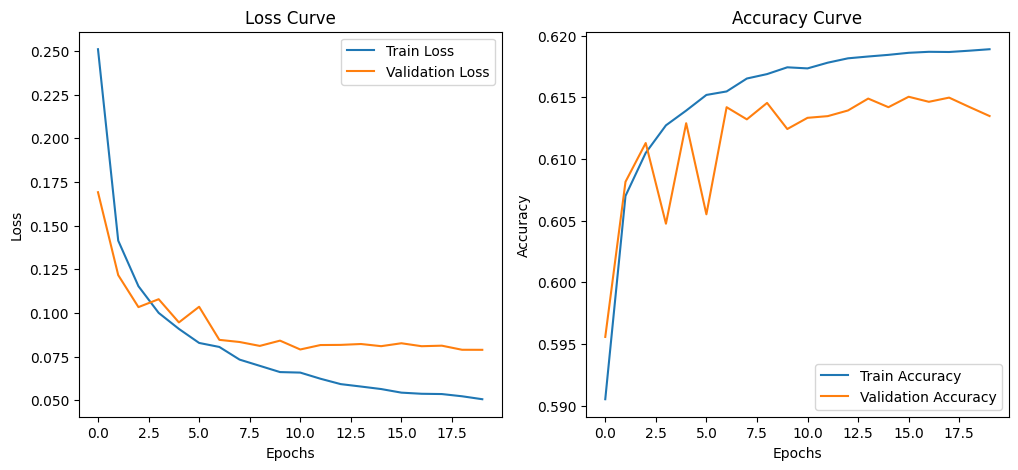

In [11]:
def unet_model(input_size=(64, 64, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create model
model = unet_model()
model.summary()

# Train the model with validation loss & accuracy tracking
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=20,
    verbose=1
)


def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

plot_history(history)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Prefetch for better performance
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
#metrics
def iou_metric(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [14]:
def unet(input_size=(64, 64, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)  # Dropout for regularization

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.2)(pool2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up1 = UpSampling2D((2, 2))(conv3)
    up1 = concatenate([up1, conv2], axis=-1)
    up1 = Dropout(0.2)(up1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up2 = UpSampling2D((2, 2))(conv4)
    up2 = concatenate([up2, conv1], axis=-1)
    up2 = Dropout(0.2)(up2)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)  # Binary segmentation

    model = Model(inputs, outputs)
    return model

# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')
print(f"Available GPUs: {gpus}")

# Use MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

# Define the model and compile it within the strategy scope
with strategy.scope():
    model = unet(input_size=(64, 64, 3))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', iou_metric, dice_coefficient])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - accuracy: 0.5827 - dice_coefficient: 0.5009 - iou_metric: 0.3457 - loss: 0.4929 - val_accuracy: 0.5542 - val_dice_coefficient: 0.7661 - val_iou_metric: 0.6211 - val_loss: 0.2730 - learning_rate: 1.0000e-04
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 106ms/step - accuracy: 0.5918 - dice_coefficient: 0.7799 - iou_metric: 0.6396 - loss: 0.2295 - val_accuracy: 0.5763 - val_dice_coefficient: 0.8160 - val_iou_metric: 0.6896 - val_loss: 0.2106 - learning_rate: 1.0000e-04
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - accuracy: 0.5996 - dice_coefficient: 0.8250 - iou_metric: 0.7024 - loss: 0.1855 - val_accuracy: 0.5828 - val_dice_coefficient: 0.8404 - val_iou_metric: 0.7250 - val_loss: 0.1857 - learning_rate: 1.0000e-04
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.6035 - dice_coefficient: 0.8489 - iou_metric: 0.7377 - 

In [15]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (7505, 64, 64, 3)
y_train shape: (7505, 64, 64, 1)
X_test shape: (1877, 64, 64, 3)
y_test shape: (1877, 64, 64, 1)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


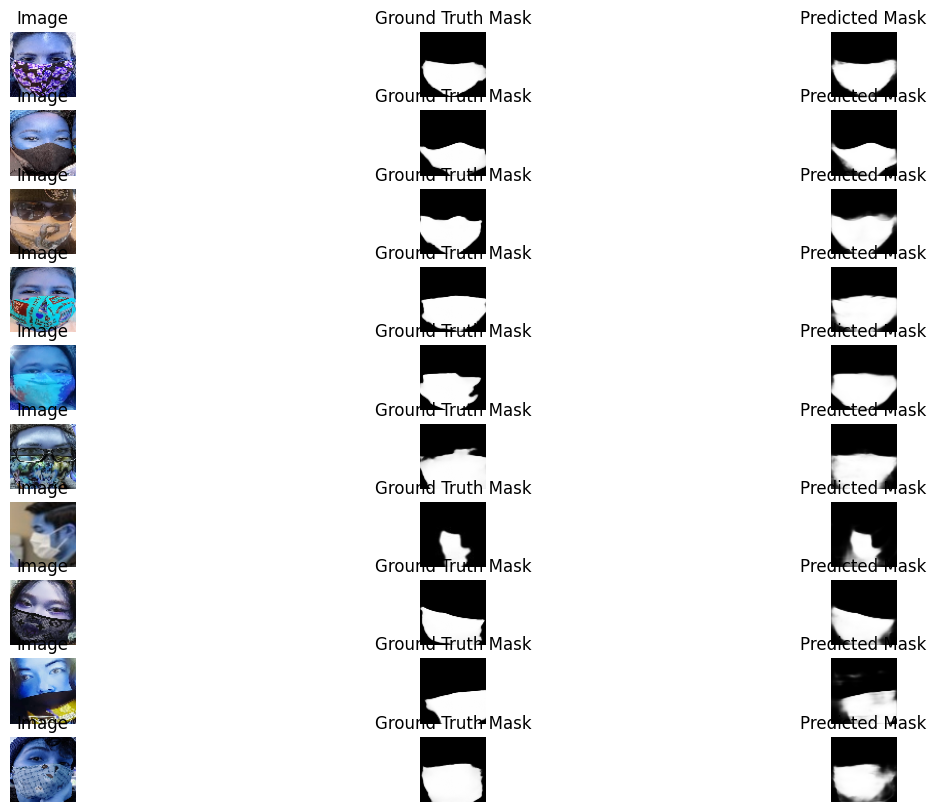

In [16]:
import matplotlib.pyplot as plt

def visualize_predictions(images, masks, predictions, num_samples=10):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Display image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis("off")

        # Display ground truth mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(masks[i], cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Display predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predictions[i], cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.show()

# Generate predictions
predictions = model.predict(X_test)

# Visualize predictions
visualize_predictions(X_test, y_test, predictions)